# Classical DFT

In [2]:
# Imports needed
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

### Functions defined for the cDFT solver. 

In [48]:
def MF_LennardJones(eps, sigma, z, beta):
    # Mean-field contribution to the free energy with lennard-jones potential
    phi = np.zeros_like(z)
    mask = abs(z) <= sigma
    phi[mask] = - 6 *np.pi *beta * eps* sigma**2 *(1/5)
    phi[~mask] = - 4 *np.pi * eps* sigma**2 * (1/5 *(sigma/z[~mask])**10 - (1/2)*(sigma/z[~mask])**4)
    return phi  
    
def w(z, eps_w, sigma_w):
    # Wall potential
    return (2 * np.pi * eps_w) * ((2/45) * (sigma_w / z)**9 - (1/3)* (sigma_w / z)**3)

def V_ex(z, h, eps_w, sigma_w):
    # External potential due to the walls
    result = np.zeros_like(z)
    mask = (z >= sigma_w) & (z <= h - sigma_w)
    result[mask] = w(z[mask], eps_w, sigma_w) + w(h - z[mask], eps_w, sigma_w)
    result[~mask] = 1e10  # unphysical region
    return result

def chem_potential(nb, eps, sigma, beta): # unit of kT
    # Chemical potential from the bulk equation of state
    return -np.log((1 - nb * sigma**3)/nb) - (32/9) * np.pi * beta * eps * sigma**3 * nb + nb/(1 - nb * sigma**3)
                                   
def denisty_profile(nz, h, z, chempot, eps, sigma, eps_w, sigma_w, beta):
    # Density profile function
    phi_mf = np.zeros_like(z)
    for i, zi in enumerate(z):
        distances = np.abs(zi - z)
        #mask = distances > 1e-10  # Exclude self-interaction (i=j)
        phi_mf[i] = np.trapz(nz * MF_LennardJones(eps, sigma, distances, beta), z)
    return (1 - nz* sigma**3) *np.exp(chempot) * np.exp( - nz * sigma**3/(1 - nz* sigma**3)) * np.exp( -beta*phi_mf) * np.exp(- beta * (V_ex(z, h, eps_w, sigma_w)))
                           
def convergence(nz_new, nz_old, tol= 1e-6):
    # Check convergence using L2 norm - no problem with division by zero
    l2_norm = np.linalg.norm(nz_new - nz_old)
    return l2_norm < tol

def Omega(nz, nb, z, h, chempot, eps, sigma, eps_w, sigma_w, beta):
    # Grand potential functional
    phi_mf = np.zeros_like(z)
    Int= np.zeros_like(z)
    for i, zi in enumerate(z):
        distances = np.abs(zi - z)
        #mask = distances > 1e-10  # Exclude self-interaction (i=j)
        phi_mf[i] = np.trapz(nz * MF_LennardJones(eps, sigma, distances, beta), z)
    mask = nz > 1e-10 
    Int[mask] = ((1/beta)*(np.log((nz[mask])/(1- nz[mask] * sigma**3)) -1 )+ (1/2)*phi_mf[mask] + V_ex(z, h, eps_w, sigma_w)[mask] - chempot)
    Ph =  (nb)/(beta*(1 - nb * sigma**3)) - 16/9 * np.pi * eps * sigma**3 * nb**2
    Omega_Ph = np.trapz(nz * Int, z) 
    return Omega_Ph + np.sum(Ph*h)
    
def solve_cDFT(n,z,  eps, sigma, eps_w, sigma_w, n_b, beta, h, Nz, max_iter=1000, tol=1e-6, alpha=0.02):
    # Main solver function for cDFT
    chempot = np.zeros_like(n)
    chempot = chem_potential(n_b, eps, sigma, beta) # phi_bulk
    print(f"Chemical potential: {chempot}") # is a constant
    for iteration in range(max_iter):  
        n_new = denisty_profile(n, h, z, chempot, eps, sigma, eps_w, sigma_w, beta)
        #print(f"Iteration {iteration}: max density = {np.max(n_new)}, min density = {np.min(n_new)}")
        n_new = alpha * n_new + (1 - alpha) * n  # Mixing for stability
        if convergence(n_new, n, tol): # check convergence
            print(f"Converged in {iteration} iterations.")
            return n_new
        n = n_new # update density profile
    print("Maximum iterations reached without convergence.")
    return n_new

### Testing the solver for one h-value and plotting the results to see if it seems valid. 

In [49]:
# Parameters
eps = 1.0
sigma = 1.0 
eps_w = 1.0
sigma_w =1.0
n_b = 0.035 # bulk density
h = 20.0 # slit width
Nz = 1000 # number of grid points
beta = 1/(eps*1.2) # inverse temperature

z = np.linspace(0.7, h-0.7, Nz) 
print(f"Grid points from {z[0]} to {z[-1]} with spacing {z[1]-z[0]}")
n = n_b * np.exp(- beta * V_ex(z, h, eps_w, sigma_w)) # Initial guess adjusted for external potential

n =solve_cDFT(n, z, eps, sigma, eps_w, sigma_w, n_b, beta, h, Nz)
    

Grid points from 0.7 to 19.3 with spacing 0.018618618618618576
Chemical potential: -3.6063054035033666
Converged in 429 iterations.


1000 1000


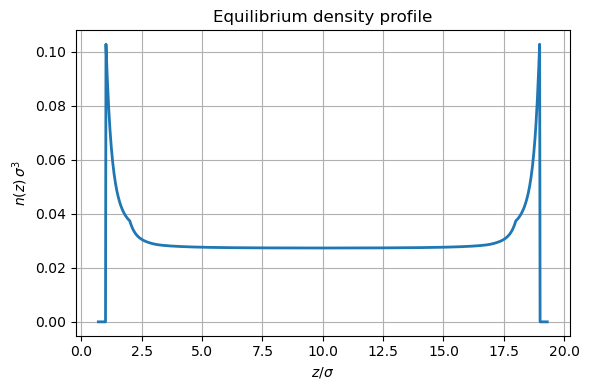

In [50]:
print(len(z), len(n))
plt.figure(figsize=(6, 4))
plt.plot(z, n, lw=2)
plt.xlabel(r"$z / \sigma$")
plt.ylabel(r"$n(z)\,\sigma^3$")
plt.title("Equilibrium density profile")
plt.grid(True)
plt.tight_layout()
plt.show()

### Generating the 30 equilibrium density profiles of the systems with wall separation 4 to 10. 

In [51]:
h = np.arange(4,10,0.2) # Slit widths 
print(len(h)) # Check length

# Parameters:
eps = 1.0
sigma = 1.0
eps_w = 1.0
sigma_w =1.0
nb = 0.035 # bulk density
Nz = 1000 # number of grid points
beta = 1/(eps*1.2) # inverse temperature

# Array to save all density profiles in
n_array = np.zeros((len(h),Nz))

for i, h_i in enumerate(h): 
    print(f"Solving for h = {h_i}")
    z = np.linspace(0.7, h_i-0.7, Nz) 
    #print(f"Grid points from {z[0]} to {z[-1]} with spacing {z[1]-z[0]}")
    # Initial density guess
    n = nb * np.exp(- beta * V_ex(z, h_i, eps_w, sigma_w))
    n_array[i] = solve_cDFT(n, z, eps, sigma, eps_w, sigma_w, n_b, beta, h_i, Nz)
    

30
Solving for h = 4.0
Chemical potential: -3.6063054035033666
Converged in 458 iterations.
Solving for h = 4.2
Chemical potential: -3.6063054035033666
Converged in 454 iterations.
Solving for h = 4.4
Chemical potential: -3.6063054035033666
Converged in 451 iterations.
Solving for h = 4.6000000000000005
Chemical potential: -3.6063054035033666
Converged in 450 iterations.
Solving for h = 4.800000000000001
Chemical potential: -3.6063054035033666
Converged in 448 iterations.
Solving for h = 5.000000000000001
Chemical potential: -3.6063054035033666
Converged in 447 iterations.
Solving for h = 5.200000000000001
Chemical potential: -3.6063054035033666
Converged in 446 iterations.
Solving for h = 5.400000000000001
Chemical potential: -3.6063054035033666
Converged in 446 iterations.
Solving for h = 5.600000000000001
Chemical potential: -3.6063054035033666
Converged in 445 iterations.
Solving for h = 5.800000000000002
Chemical potential: -3.6063054035033666
Converged in 444 iterations.
Solving 

### Plotting the equilibrium density profiles for 3 different slit widths. 

Areas under the curves: [0.12319108 0.20340044 0.27998965]
Grand potentials: [-0.08855496 -0.1332257  -0.17768409]


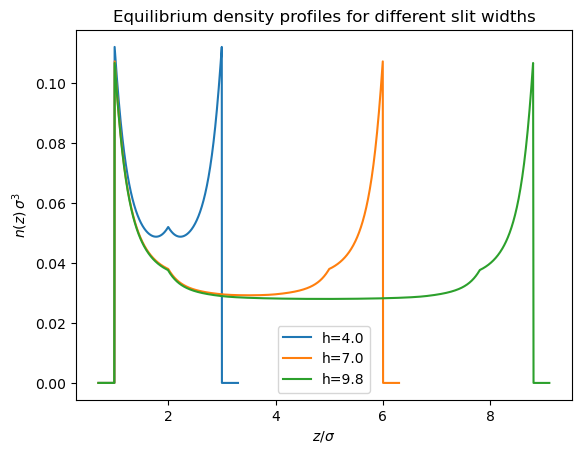

In [52]:
areas = np.zeros(3)
omegas = np.zeros(3)
h = np.arange(4,10,0.2) # Slit widths 
args = [0, 15, -1] #np.arange(4,10,0.2)
wh = np.zeros(3)

for j,i in enumerate(args):
    areas[j] = np.trapz(n_array[i], np.linspace(0.7, h[i]-0.7, Nz))
    omegas[j] = Omega(n_array[i], nb, np.linspace(0.7, h[i]-0.7, Nz), h[i], chem_potential(n_b, eps, sigma, beta), eps, sigma, eps_w, sigma_w, beta)
    wh[j] = w(h[i], eps_w, sigma_w)
    plt.plot(np.linspace(0.7, h[i]-0.7, Nz), n_array[i], label=f"h={h[i]:.1f}")
plt.xlabel(r"$z / \sigma$")
plt.ylabel(r"$n(z)\,\sigma^3$")
plt.title("Equilibrium density profiles for different slit widths")
plt.legend()
#plt.savefig("eq_density_T1.pdf")
print("Areas under the curves:", areas)
print("Grand potentials:", omegas)

### Plotting the grand potential per unit area for each slit width. 

Areas under the curves: [0.12319108 0.20340044 0.27998965]
Grand potentials: [-0.08855496 -0.09016536 -0.09385422 -0.09621639 -0.09815696 -0.10134214
 -0.10537014 -0.1086346  -0.11064872 -0.11352169 -0.11668648 -0.1204697
 -0.12453941 -0.12728019 -0.12989225 -0.1332257  -0.13688708 -0.14071191
 -0.14237852 -0.14700797 -0.14877195 -0.15052813 -0.15615588 -0.15868487
 -0.1613706  -0.16459024 -0.16802065 -0.1706257  -0.17413166 -0.17768409]


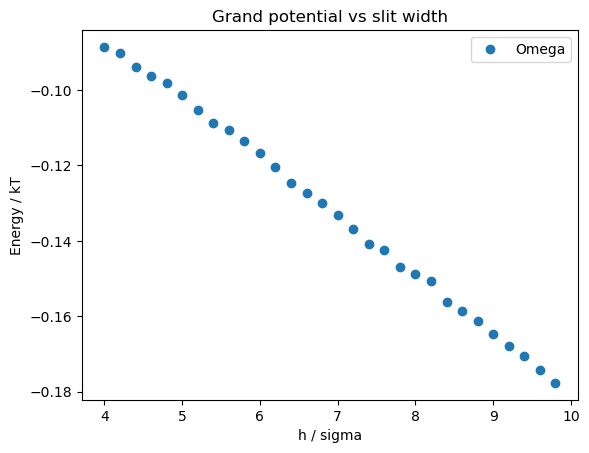

In [53]:
omegas = np.zeros(30)
h = np.arange(4,10,0.2)


for i, j in enumerate(h):
    omegas[i] = Omega(n_array[i], nb, np.linspace(0.7, j-0.7, Nz), j, chem_potential(n_b, eps, sigma, beta), eps, sigma, eps_w, sigma_w, beta)

print("Areas under the curves:", areas)
print("Grand potentials:", omegas)
plt.plot(h, omegas,'o', label="Omega")

plt.xlabel("h / sigma")
plt.ylabel("Energy / kT")
plt.title("Grand potential vs slit width")
plt.legend()
#plt.savefig("grandpot.pdf")

### Functions for computing the solvation force analytically and numerically. 

In [75]:
def derivative_w(z, eps_w, sigma_w):
    return (2 * np.pi * eps_w ) * ((2/5) * sigma_w**9 / z**10 - sigma_w**3 / z**4)


def derivative_V_ex(z, h, eps_w, sigma_w):
         # ∂V_ex/∂h where V_ex = w(z) + w(h-z)
         # ∂w(z)/∂h = 0
         # ∂w(h-z)/∂h = dw/dr * ∂(h-z)/∂h = dw/dr * (+1) where r = h-z
         result = np.zeros_like(z)
         mask = (z >= sigma_w) & (z <= h - sigma_w)
         result[mask] = derivative_w(h - z[mask], eps_w, sigma_w)  # Only the 
        #second wall contributes
         result[~mask] = 1e10
         return result

   #The solvation force formula should be:

def solvation_force(nz, z, h, nb, eps, sigma, eps_w, sigma_w, beta):
    P = (1/beta)*nb/(1 - nb * sigma**3) - (16/9) * np.pi * eps * sigma**3* nb**2
    Integrand = np.trapz(nz * derivative_V_ex(z, h, eps_w, sigma_w), z)
    return - P - Integrand  # f = -dΩ/dh = -P - ∫n(z)∂V_ex/∂h dz


def numerical_dOmega_dh(n_array, h_center, eps, sigma, eps_w, sigma_w, n_b, beta, Nz=1000, dh=0.001):
         """
         Compute -dΩ/dh numerically using central differences and the solver.
         n_array: array of density profiles for different h values
         h_center: the slit width at which to compute the derivative
         dh: small change in h for numerical differentiation
         """
         chempot = chem_potential(n_b, eps, sigma, beta) # phi_bulk a constant
        
         # Compute Omega at h + dh
         z_plus = np.linspace(0.7, h_center + dh - 0.7, Nz)
         nz_plus = solve_cDFT(n_array, z_plus,eps, sigma, eps_w, sigma_w, n_b, beta, h_center + dh, Nz)
         omega_plus = Omega(nz_plus, n_b, z_plus, h_center + dh, chempot, eps, sigma, eps_w, sigma_w, beta)

         # Compute Omega at h - dh
         z_minus = np.linspace(0.7, h_center - dh - 0.7, Nz)
         nz_minus = solve_cDFT(n_array, z_minus, eps, sigma, eps_w, sigma_w, n_b, beta, h_center - dh, Nz)
         omega_minus = Omega(nz_minus, n_b,z_minus, h_center - dh, chempot, eps, sigma, eps_w, sigma_w, beta)

         return -(omega_plus - omega_minus) / (2 * dh)




In [76]:
f_numerical = np.zeros(30)
f_analytical = np.zeros(30)
for arg in range(0,30):
    f_numerical[arg] = numerical_dOmega_dh(n_array[arg], h[arg], eps, sigma, eps_w, sigma_w, n_b, beta, Nz=1000, dh=0.0001)
    f_analytical[arg] = solvation_force(n_array[arg], np.linspace(0.7, h[arg]-0.7, Nz), h[arg], n_b, eps, sigma, eps_w, sigma_w, beta)

Chemical potential: -3.6063054035033666
Converged in 35 iterations.
Chemical potential: -3.6063054035033666
Converged in 0 iterations.
Chemical potential: -3.6063054035033666
Converged in 30 iterations.
Chemical potential: -3.6063054035033666
Converged in 0 iterations.
Chemical potential: -3.6063054035033666
Converged in 173 iterations.
Chemical potential: -3.6063054035033666
Converged in 119 iterations.
Chemical potential: -3.6063054035033666
Converged in 23 iterations.
Chemical potential: -3.6063054035033666
Converged in 0 iterations.
Chemical potential: -3.6063054035033666
Converged in 21 iterations.
Chemical potential: -3.6063054035033666
Converged in 0 iterations.
Chemical potential: -3.6063054035033666
Converged in 20 iterations.
Chemical potential: -3.6063054035033666
Converged in 0 iterations.
Chemical potential: -3.6063054035033666
Converged in 18 iterations.
Chemical potential: -3.6063054035033666
Converged in 0 iterations.
Chemical potential: -3.6063054035033666
Converged in

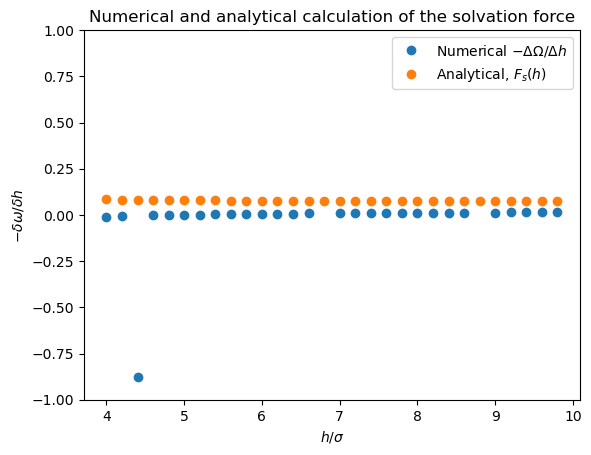

In [77]:

plt.plot(h, f_numerical, 'o', label=r"Numerical $-\Delta\Omega/\Delta h$")
plt.plot(h, f_analytical, 'o', label=r"Analytical, $F_s(h)$")
plt.ylim(-1,1)
plt.title("Numerical and analytical calculation of the solvation force")
plt.xlabel(r"$h/\sigma$")
plt.ylabel(r"$-\delta \omega/\delta h$")
plt.legend()

### Numerical computation of solvation force using interpolation (faster)

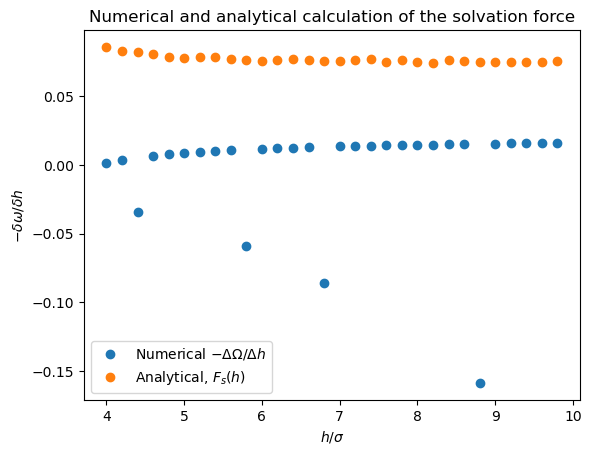

In [78]:
# Function to compute Omega for a given h with a fixed density profile
def compute_omega_at_h(h_val, n_interp, eps, sigma, eps_w, sigma_w, n_b, beta, Nz=1000):
    """
    Compute Omega at a specific h value.
    n_interp: function that interpolates density from one h to another
    """
    z_new = np.linspace(0.7, h_val - 0.7, Nz)
    # Interpolate density profile to new grid
    nz_new = n_interp(z_new)
    chempot = chem_potential(n_b, eps, sigma, beta)
    return Omega(nz_new, n_b, z_new, h_val, chempot, eps, sigma, eps_w, sigma_w, beta)

# Compute dΩ/dh using finite differences
def numerical_dOmega_dh(n_array, h_center, eps, sigma, eps_w, sigma_w, n_b, beta, dh=0.01, Nz=1000):
    """
    Compute -dΩ/dh numerically using central differences
    """
    # Create interpolation function for the density at h_center
    Nz = len(n_array)
    z_center = np.linspace(0.7, h_center - 0.7, Nz)
    
    # Interpolate density as function of position
    n_interp = interp1d(z_center, n_array, kind='nearest', fill_value='extrapolate')
    
    # Compute Omega at h + dh and h - dh
    omega_plus = compute_omega_at_h(h_center + dh, n_interp, eps, sigma, eps_w, sigma_w, n_b, beta, Nz)
    omega_minus = compute_omega_at_h(h_center - dh, n_interp, eps, sigma, eps_w, sigma_w, n_b, beta, Nz)
    
    # Central difference
    dOmega_dh = (omega_plus - omega_minus) / (2 * dh)
    
    return -dOmega_dh  # Return -dΩ/dh for solvation force
f_numerical = np.zeros(30)
for i in range(30):
    f_numerical[i] = numerical_dOmega_dh(n_array[i], h[i], eps, sigma, eps_w, sigma_w, n_b, beta, dh=0.001, Nz=10000)
   
plt.plot(h, f_numerical, 'o', label=r"Numerical $-\Delta\Omega/\Delta h$")
plt.plot(h, f_analytical, 'o', label=r"Analytical, $F_s(h)$")
#plt.ylim(0.025,0.1)
plt.title("Numerical and analytical calculation of the solvation force")
plt.xlabel(r"$h/\sigma$")
plt.ylabel(r"$-\delta \omega/\delta h$")
plt.legend()
#plt.savefig("num_vs_ana.pdf")